# 🛒 Market Basket Analysis — Data Preprocessing

This notebook connects to a PostgreSQL database, loads transaction data, 
and prepares it in the correct format for association rule mining.



In [ ]:
# Import required Python libraries
!pip install pandas numpy matplotlib seaborn sqlalchemy mlxtend




In [ ]:
pip install --upgrade pip

In [ ]:
import sys
print(sys.executable)



In [ ]:
source venv/bin/activate


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [9]:
from sqlalchemy import create_engine
from urllib.parse import quote_plus

# PostgreSQL credentials
db_user = 'postgres'
db_password = 'Chetan@1234'       # original password
db_host = 'localhost'
db_name = 'Market_basket_project'

# URL-encode the password
db_password_encoded = quote_plus(db_password)

# Create connection string with encoded password
connection_string = f'postgresql+psycopg2://{db_user}:{db_password_encoded}@{db_host}/{db_name}'

# Create engine
engine = create_engine(connection_string)

# Test connection
try:
    connection = engine.connect()
    print("✅ Connected to PostgreSQL successfully!")
    connection.close()
except Exception as e:
    print("❌ Connection failed:", e)


✅ Connected to PostgreSQL successfully!


In [12]:
import pandas as pd

# SQL query to fetch transactions
query = "SELECT transaction_id, item FROM transactionss ORDER BY transaction_id;"

# Load data into a pandas DataFrame
df = pd.read_sql(query, engine)

# Preview the first 10 rows
df.head(10)


,transaction_id,item
0,T1,Bread
1,T1,Butter
2,T1,Cheese
3,T1,Milk
4,T1,Juice
5,T1,Eggs
6,T10,Diaper
7,T10,Milk
8,T10,Beer
9,T100,Butter


In [13]:
# Group items by transaction
basket = df.groupby('transaction_id')['item'].apply(list).reset_index()
basket.head(10)



,transaction_id,item
0,T1,"[Bread, Butter, Cheese, Milk, Juice, Eggs]"
1,T10,"[Diaper, Milk, Beer]"
2,T100,"[Butter, Diaper, Eggs, Bread, Cola, Chips]"
3,T101,"[Beer, Diaper, Cola, Eggs, Chips]"
4,T102,"[Chips, Cola, Milk, Bread]"
5,T103,[Chips]
6,T104,"[Chips, Cola, Butter, Juice, Beer]"
7,T105,[Juice]
8,T106,"[Butter, Cheese, Cola, Milk, Eggs, Beer]"
9,T107,"[Milk, Cola, Eggs, Bread, Diaper]"


In [14]:
from mlxtend.preprocessing import TransactionEncoder

# Convert basket to list of lists
transactions = basket['item'].tolist()

# Initialize encoder
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)

# Convert to DataFrame
df_encoded = pd.DataFrame(te_array, columns=te.columns_)
df_encoded.head()


,Beer,Bread,Butter,Cheese,Chips,Cola,Diaper,Eggs,Juice,Milk
0,False,True,True,True,False,False,False,True,True,True
1,True,False,False,False,False,False,True,False,False,True
2,False,True,True,False,True,True,True,True,False,False
3,True,False,False,False,True,True,True,True,False,False
4,False,True,False,False,True,True,False,False,False,True


In [15]:
from mlxtend.frequent_patterns import apriori, association_rules

# Minimum support = 0.1 (adjust as needed)
frequent_itemsets = apriori(df_encoded, min_support=0.1, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
3,0.425,(Cheese)
7,0.395,(Eggs)
2,0.385,(Butter)
9,0.370,(Milk)
4,0.365,(Chips)
5,0.360,(Cola)
1,0.355,(Bread)
6,0.345,(Diaper)
8,0.310,(Juice)
0,0.305,(Beer)


In [16]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules.sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
13,(Cheese),"(Eggs, Milk)",0.425,0.155,0.105,0.247059,1.593928,1.0,0.039125,1.122266,0.648033,0.221053,0.108945,0.462239
12,"(Eggs, Milk)",(Cheese),0.155,0.425,0.105,0.677419,1.593928,1.0,0.039125,1.782500,0.440969,0.221053,0.438990,0.462239
15,(Milk),"(Cheese, Eggs)",0.370,0.200,0.105,0.283784,1.418919,1.0,0.031000,1.116981,0.468632,0.225806,0.104730,0.404392
10,"(Cheese, Eggs)",(Milk),0.200,0.370,0.105,0.525000,1.418919,1.0,0.031000,1.326316,0.369048,0.225806,0.246032,0.404392
8,(Cheese),(Milk),0.425,0.370,0.210,0.494118,1.335453,1.0,0.052750,1.245349,0.436853,0.358974,0.197012,0.530843
9,(Milk),(Cheese),0.370,0.425,0.210,0.567568,1.335453,1.0,0.052750,1.329687,0.398715,0.358974,0.247944,0.530843
5,(Milk),(Beer),0.370,0.305,0.145,0.391892,1.284891,1.0,0.032150,1.142889,0.351943,0.273585,0.125024,0.433651
4,(Beer),(Milk),0.305,0.370,0.145,0.475410,1.284891,1.0,0.032150,1.200937,0.319028,0.273585,0.167317,0.433651
0,(Beer),(Cheese),0.305,0.425,0.165,0.540984,1.272903,1.0,0.035375,1.252679,0.308480,0.292035,0.201711,0.464609
1,(Cheese),(Beer),0.425,0.305,0.165,0.388235,1.272903,1.0,0.035375,1.136058,0.372859,0.292035,0.119763,0.464609


/var/folders/ww/y2wf6c2124l50s_98xy1h9mw0000gn/T/ipykernel_77526/1447723935.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=item_counts.index, y=item_counts.values, palette='viridis')


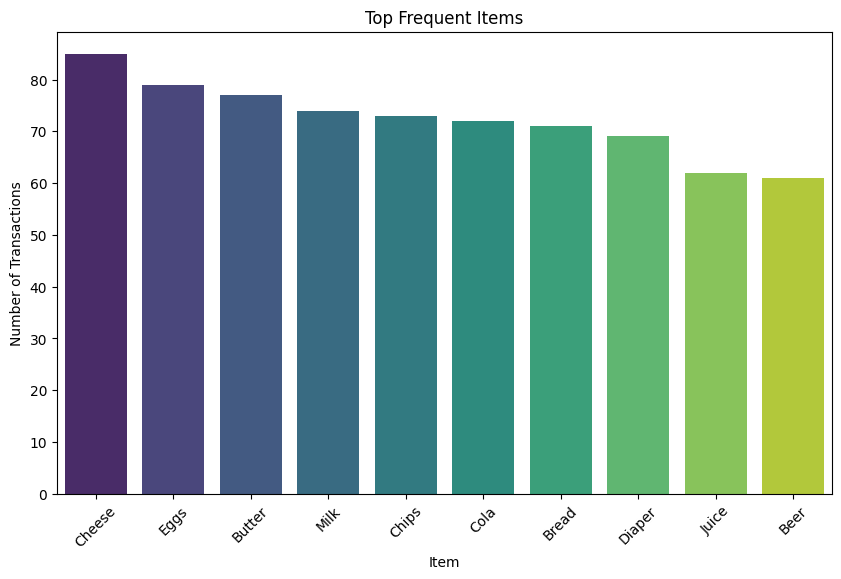

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count total occurrences of each item
item_counts = df['item'].value_counts()

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=item_counts.index, y=item_counts.values, palette='viridis')
plt.title("Top Frequent Items")
plt.ylabel("Number of Transactions")
plt.xlabel("Item")
plt.xticks(rotation=45)
plt.show()


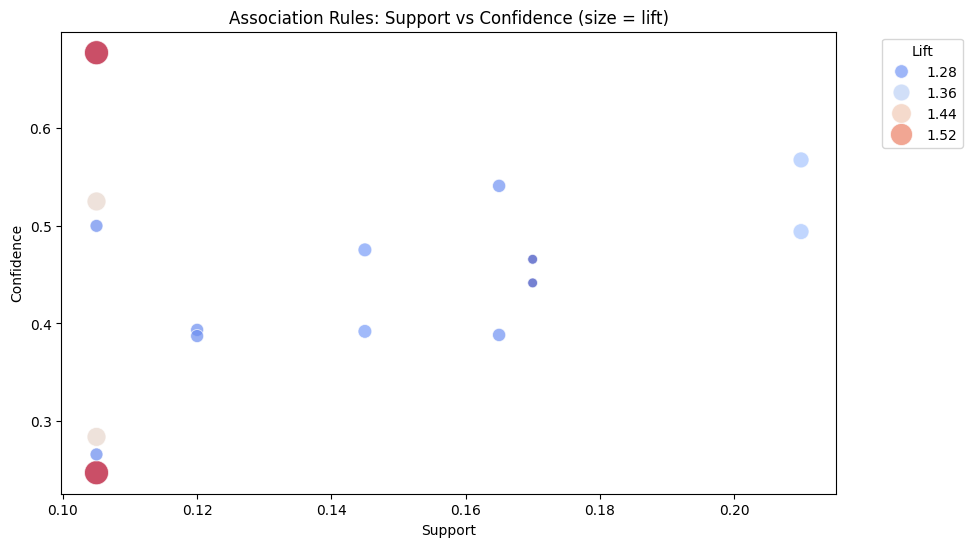

In [18]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift',
                data=rules, palette='coolwarm', sizes=(50, 300), alpha=0.7)
plt.title("Association Rules: Support vs Confidence (size = lift)")
plt.xlabel("Support")
plt.ylabel("Confidence")
plt.legend(title='Lift', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


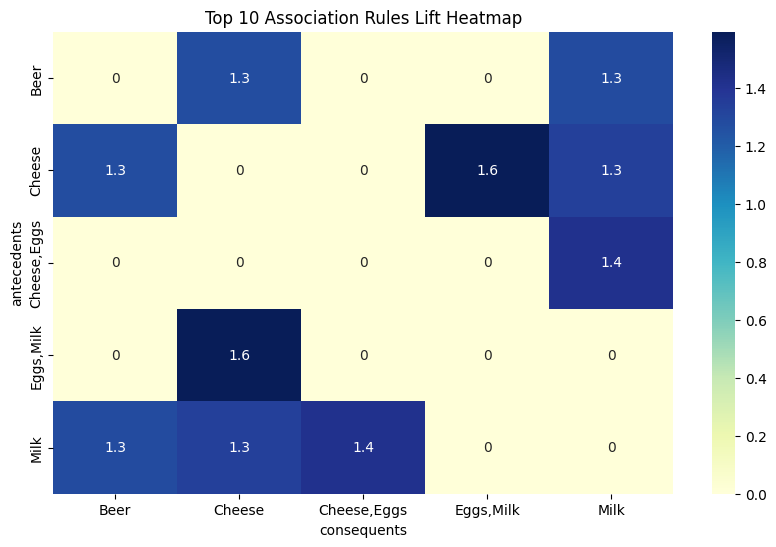

In [19]:
# Pivot rules for heatmap
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
heatmap_data = pd.crosstab(top_rules['antecedents'].apply(lambda x: ','.join(list(x))),
                           top_rules['consequents'].apply(lambda x: ','.join(list(x))),
                           values=top_rules['lift'], aggfunc='max').fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title("Top 10 Association Rules Lift Heatmap")
plt.show()


In [20]:
# Count total occurrences of each item
item_counts = df['item'].value_counts()
item_counts


item
Cheese    85
Eggs      79
Butter    77
Milk      74
Chips     73
Cola      72
Bread     71
Diaper    69
Juice     62
Beer      61
Name: count, dtype: int64

In [21]:
frequent_itemsets.sort_values(by='support', ascending=False).head(10)


,support,itemsets
3,0.425,(Cheese)
7,0.395,(Eggs)
2,0.385,(Butter)
9,0.370,(Milk)
4,0.365,(Chips)
5,0.360,(Cola)
1,0.355,(Bread)
6,0.345,(Diaper)
8,0.310,(Juice)
0,0.305,(Beer)


In [22]:
rules.sort_values(by='lift', ascending=False).head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
13,(Cheese),"(Eggs, Milk)",0.425,0.155,0.105,0.247059,1.593928,1.0,0.039125,1.122266,0.648033,0.221053,0.108945,0.462239
12,"(Eggs, Milk)",(Cheese),0.155,0.425,0.105,0.677419,1.593928,1.0,0.039125,1.782500,0.440969,0.221053,0.438990,0.462239
15,(Milk),"(Cheese, Eggs)",0.370,0.200,0.105,0.283784,1.418919,1.0,0.031000,1.116981,0.468632,0.225806,0.104730,0.404392
10,"(Cheese, Eggs)",(Milk),0.200,0.370,0.105,0.525000,1.418919,1.0,0.031000,1.326316,0.369048,0.225806,0.246032,0.404392
8,(Cheese),(Milk),0.425,0.370,0.210,0.494118,1.335453,1.0,0.052750,1.245349,0.436853,0.358974,0.197012,0.530843
9,(Milk),(Cheese),0.370,0.425,0.210,0.567568,1.335453,1.0,0.052750,1.329687,0.398715,0.358974,0.247944,0.530843
5,(Milk),(Beer),0.370,0.305,0.145,0.391892,1.284891,1.0,0.032150,1.142889,0.351943,0.273585,0.125024,0.433651
4,(Beer),(Milk),0.305,0.370,0.145,0.475410,1.284891,1.0,0.032150,1.200937,0.319028,0.273585,0.167317,0.433651
0,(Beer),(Cheese),0.305,0.425,0.165,0.540984,1.272903,1.0,0.035375,1.252679,0.308480,0.292035,0.201711,0.464609
1,(Cheese),(Beer),0.425,0.305,0.165,0.388235,1.272903,1.0,0.035375,1.136058,0.372859,0.292035,0.119763,0.464609
